# QC ATAC (E)
- August 2024: use PE50 fastq trimming
- E = estradiol-benzoate-injected female mice (NEW FORMULA IN JULY 2024)
- GFP sorted for Esr1+ Layer 6 neurons

## Set up correct conda environment


In [1]:
.libPaths()

[1] "/home/users/xjluo/miniconda3/envs/jupyter_env/lib/R/library"

In [2]:
.libPaths('/home/groups/tttt/xjluo/miniconda3/envs/single_cell_Seurat_v5/lib/R/library')
.libPaths()

[1] "/home/groups/tttt/xjluo/miniconda3/envs/single_cell_Seurat_v5/lib/R/library"
[2] "/home/users/xjluo/miniconda3/envs/jupyter_env/lib/R/library"

## Load packages

In [3]:
library(tidyverse)
library(viridis)
library(Seurat)
library(Signac)
library(Azimuth)
library(EnsDb.Mmusculus.v79)
library(BSgenome.Mmusculus.UCSC.mm10)
library(ggpointdensity)
library(ggExtra)

set.seed(1234)
options(repr.matrix.max.cols=100, repr.matrix.max.rows=50)
options(warn=-1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



Attaching shinyBS

Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following ob

In [4]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/users/xjluo/miniconda3/envs/jupyter_env/lib/libopenblasp-r0.3.21.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggExtra_0.10.1                     ggpointdensity_0.1.0              
 [3] BSgenome.Mmusculus.UCSC.mm10_1.4.3 BSgenome_1.68.0                   
 [5] rtracklayer_1.60.1                 Bi

## E or V

In [5]:
sample <- 'E2'

## Paths

In [6]:
data_master_dir <- '/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC'

data_master_dir

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC"

In [7]:
# fragments files
frag_file <- paste0(data_master_dir, '/', 'outs/', sample, '_outs_trimmed/', 'fragments.tsv.gz')

# raw peak bc matrices
atac_filtered_feature_bc_matrix_path <- paste0(data_master_dir, '/', 'outs/', sample, '_outs_trimmed/', 'filtered_peak_bc_matrix.h5')


In [8]:
frag_file
atac_filtered_feature_bc_matrix_path

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/outs/E2_outs_trimmed/fragments.tsv.gz"

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/outs/E2_outs_trimmed/filtered_peak_bc_matrix.h5"

In [9]:
# MACS peak-calling software
macs_path <- '/home/groups/tttt/xjluo/miniconda3/envs/macs3_env/bin/macs3'

In [10]:
# outputs
outdir <- '/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc'

outdir

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc"

In [11]:
# save ATAC objects here
save_dir <- paste0(outdir, '/', 'ATAC')
save_dir

# Ensure the directory exists
if (!dir.exists(save_dir)) {
  dir.create(save_dir, recursive=TRUE)
}

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC"

In [12]:
# Define the directory to save plots
plot_save_dir <- '/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step3_figures'
plot_save_dir_qc <- paste0(plot_save_dir, '/', '01_qc', '/', sample)

plot_save_dir_qc

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step3_figures/01_qc/E2"

## Load counts

In [13]:
counts.mtx <- Read10X_h5(atac_filtered_feature_bc_matrix_path)

In [14]:
head(colnames(counts.mtx))

[1] "AAACGAAAGAAATCTG-1" "AAACGAAAGACTAATG-1" "AAACGAAAGGAAGGTA-1"
[4] "AAACGAACACCGTTGG-1" "AAACGAACATCCGTAA-1" "AAACGAAGTCACAGGA-1"

## Create Seurat objects
- https://stuartlab.org/signac/articles/pbmc_vignette.html

In [15]:
# get gene annotations for mm10
annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)
seqlevelsStyle(annotation) <- "UCSC"

In [16]:
ChromatinAssay <- CreateChromatinAssay(
    counts = counts.mtx,    
    sep = c(":", "-"),
    fragments = frag_file,
    annotation = annotation
)
    

Computing hash



In [17]:
obj <- CreateSeuratObject(
    counts = ChromatinAssay,
    assay = "ATAC"
)
     

In [18]:
obj

An object of class Seurat 
92076 features across 2624 samples within 1 assay 
Active assay: ATAC (92076 features, 0 variable features)
 2 layers present: counts, data

### Check object contents

In [19]:
head(rownames(GetAssayData(obj, assay = 'ATAC', slot = 'data')))
head(colnames(GetAssayData(obj, assay = 'ATAC', slot = 'data')))
dim(GetAssayData(obj, assay = 'ATAC', slot = 'data'))

[1] "chr1-3113265-3114175" "chr1-3119884-3120702" "chr1-3121339-3122074"
[4] "chr1-3288104-3289001" "chr1-3292421-3293262" "chr1-3309720-3310633"

[1] "AAACGAAAGAAATCTG-1" "AAACGAAAGACTAATG-1" "AAACGAAAGGAAGGTA-1"
[4] "AAACGAACACCGTTGG-1" "AAACGAACATCCGTAA-1" "AAACGAAGTCACAGGA-1"

[1] 92076  2624

In [20]:
head(obj@meta.data)
dim(obj@meta.data)

,orig.ident,nCount_ATAC,nFeature_ATAC
,<fct>,<dbl>,<int>
AAACGAAAGAAATCTG-1,SeuratProject,8761,3688
AAACGAAAGACTAATG-1,SeuratProject,9969,4851
AAACGAAAGGAAGGTA-1,SeuratProject,2268,1141
AAACGAACACCGTTGG-1,SeuratProject,40019,15307
AAACGAACATCCGTAA-1,SeuratProject,27683,11724
AAACGAAGTCACAGGA-1,SeuratProject,30986,12169


[1] 2624    3

## Step 1: QC

### Thresholds
- Soumya Kundu, Selin Jessa (Kundaje Lab)

In [21]:
min_ncount_atac <- 15000
min_tss_enrich <- 2.5

max_ncount_atac <- quantile(obj$nCount_ATAC, prob=0.995)

print(paste('Max nCount_ATAC: ', max_ncount_atac))

[1] "Max nCount_ATAC:  53218.2399999999"


# QC

In [22]:
DefaultAssay(obj) <- "ATAC"

obj <- NucleosomeSignal(obj)
obj <- TSSEnrichment(obj, fast=FALSE)
     

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



## Visualize QC

### Nucleosomal signal

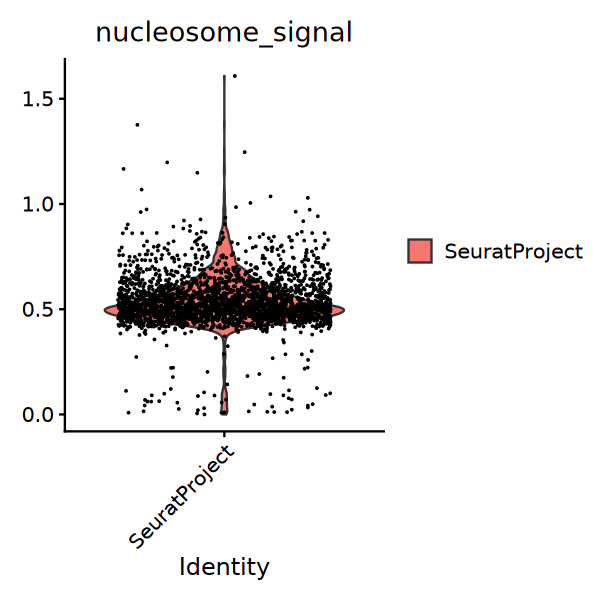

In [23]:
options(repr.plot.width=5, repr.plot.height=5)

VlnPlot(
    object = obj,
    features = "nucleosome_signal"
)

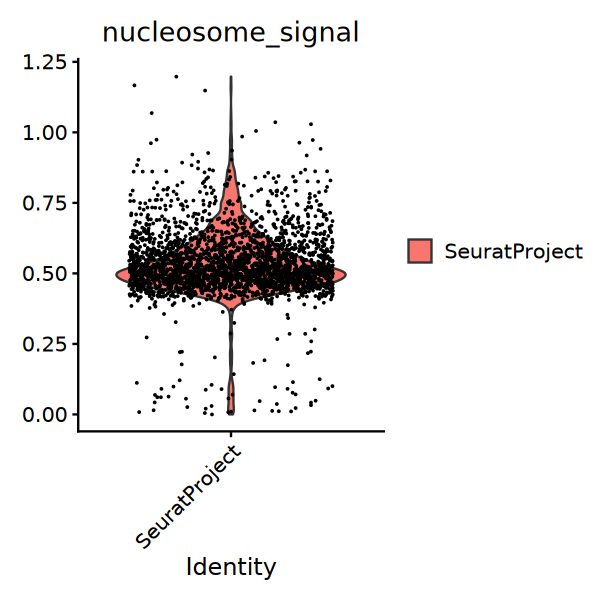

In [24]:
options(repr.plot.width=5, repr.plot.height=5)

VlnPlot(
    object = obj,
    features = "nucleosome_signal",
    y.max = 1.2
)

## Basic metrics

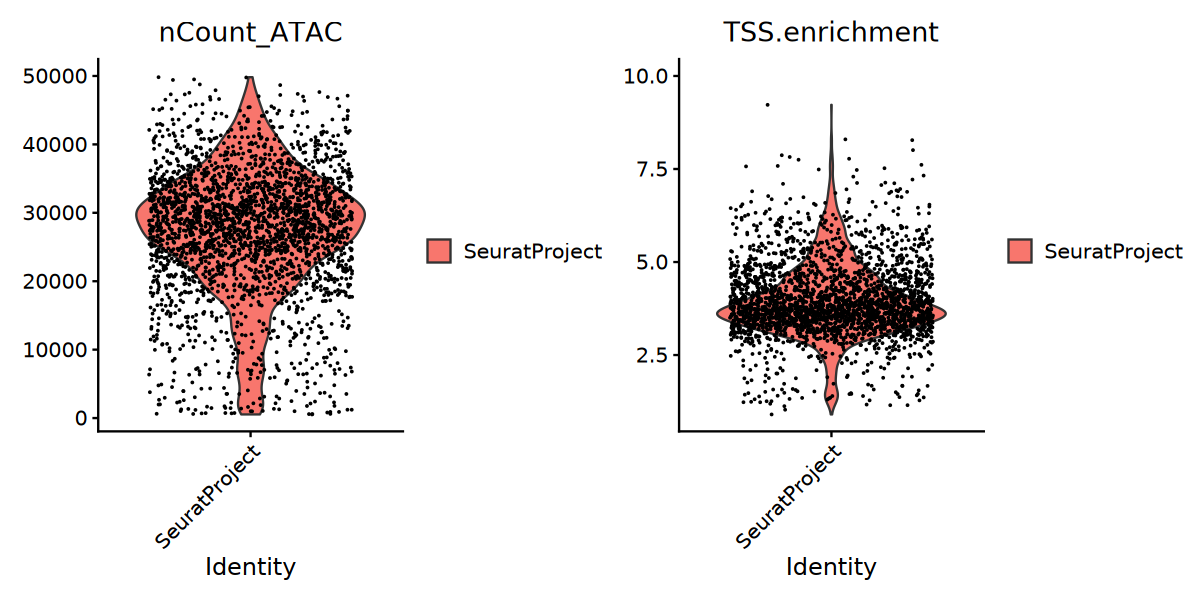

In [25]:
options(repr.plot.width=10, repr.plot.height=5)

atac1 <- VlnPlot(
    object = obj,
    features = "nCount_ATAC",
    y.max = 50000,
)


atac2 <- VlnPlot(
    object = obj,
    features = "TSS.enrichment",
    y.max = 10,
)

(atac1 | atac2)
     

### ATAC: TSS Enrichment vs. Counts


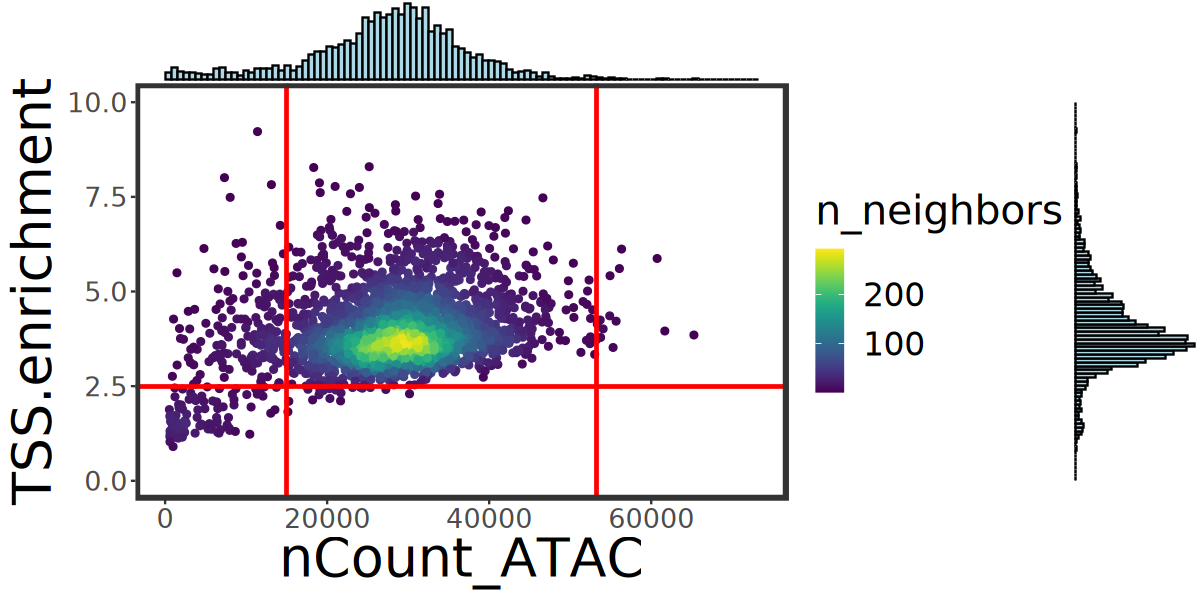

In [26]:
options(repr.plot.width=10, repr.plot.height=5)

# Custom theme modifications
theme_custom <- theme_bw() + 
  theme(
    text = element_text(size=24), # Set text to Arial and increase size
    axis.title = element_text(size=32), # Double size for axis titles
    axis.text = element_text(size=16),  # Double size for axis text
    panel.border = element_rect(size=2),  # Thicker plot borders
    panel.grid = element_blank()  # Remove gridlines
  )

# Create scatter plots with modified themes
scatter5 <- ggplot(obj@meta.data, aes(x=nCount_ATAC, y=TSS.enrichment)) +
  geom_pointdensity() +
  scale_color_viridis() +
  theme_custom +
  geom_vline(xintercept=min_ncount_atac, size=1, color='red') +
  geom_hline(yintercept=min_tss_enrich, size=1, color='red') +
  geom_vline(xintercept=max_ncount_atac, size=1, color='red') +
  xlim(0, max_ncount_atac + 20000) +
  ylim(0, 10)

scatter6 <- ggplot(obj@meta.data, aes(x=nCount_ATAC, y=TSS.enrichment)) +
  geom_pointdensity() +
  scale_color_viridis() +
  theme_custom +
  geom_vline(xintercept=min_ncount_atac, size=1, color='red') +
  geom_hline(yintercept=min_tss_enrich, size=1, color='red') +
  geom_vline(xintercept=max_ncount_atac, size=1, color='red') +
  xlim(0, min_ncount_atac + 10000) +
  ylim(0, 10)

# Add marginal histograms with custom settings
scatter5_marg <- ggMarginal(scatter5, type="histogram", bins=100, fill="lightblue")
scatter6_marg <- ggMarginal(scatter6, type="histogram", bins=100, fill="lightblue")

# Display the modified plot
scatter5_marg


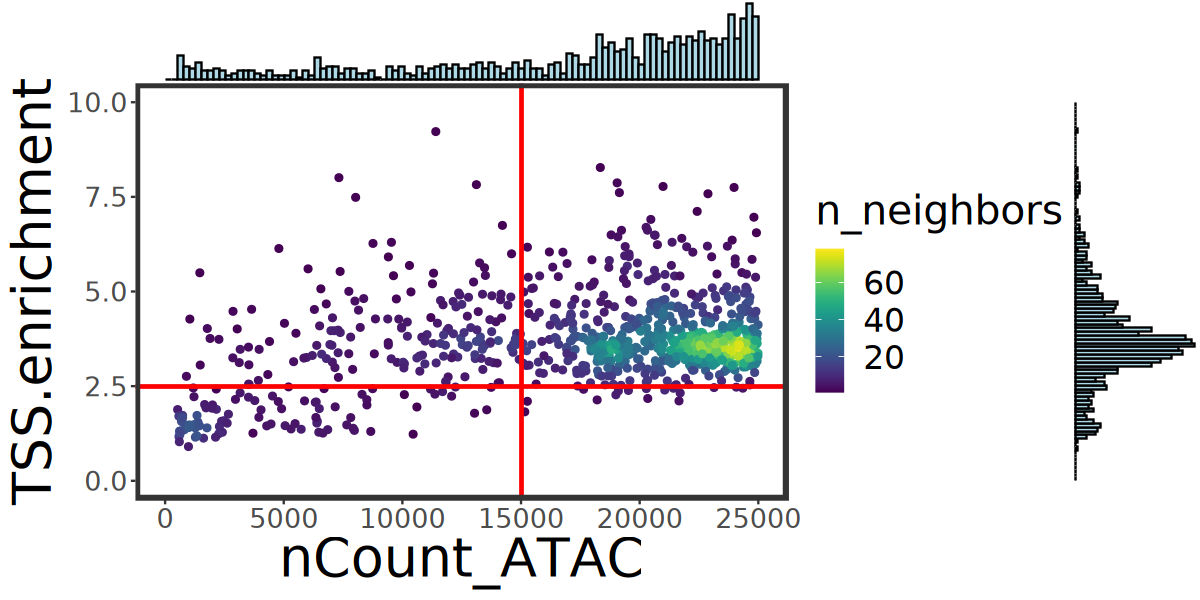

In [27]:
scatter6_marg

### Fragment Length Distribution and TSS Enrichment


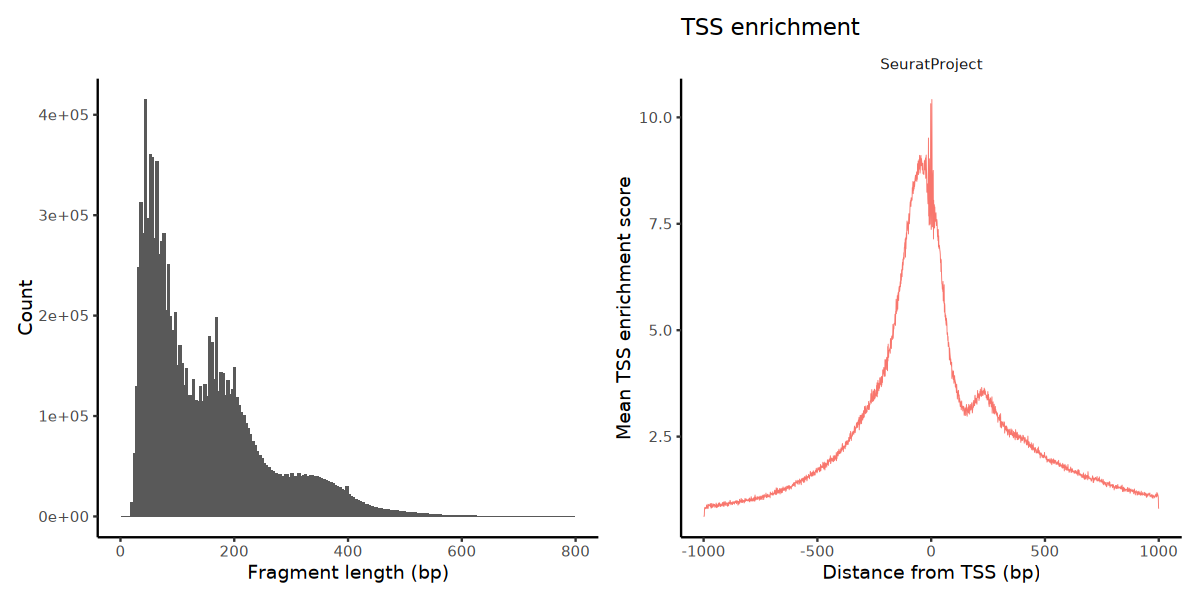

In [28]:
options(repr.plot.width=10, repr.plot.height=5)

FragmentHistogramPlot <- FragmentHistogram(object=obj, 
                           region = "chr1-1-195471971",    # http://hgdownload.cse.ucsc.edu/goldenpath/mm10/bigZips/mm10.chrom.sizes
                           assay='ATAC')

TSSDistrPlot <- TSSPlot(object=obj, assay='ATAC')

combined_plot <- FragmentHistogramPlot | TSSDistrPlot

combined_plot

### Save unfiltered object (with filtered barcode matrix)

In [29]:
saveRDS_path <- paste0(save_dir, '/1_unfiltered_objects/', sample, ".ATAC.unfiltered.Seurat.v5.rds")

saveRDS(obj, file = saveRDS_path)

print(paste('Saved unfiltered RDS to:', saveRDS_path))

obj
Version(obj)

[1] "Saved unfiltered RDS to: /oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/1_unfiltered_objects/E2.ATAC.unfiltered.Seurat.v5.rds"


An object of class Seurat 
92076 features across 2624 samples within 1 assay 
Active assay: ATAC (92076 features, 0 variable features)
 2 layers present: counts, data

[1] '5.0.2'

# Filter cells

In [30]:
# filter out low quality cells
filtered_pre_macs <- subset(
  x = obj,
  subset = TSS.enrichment > min_tss_enrich &
           nCount_ATAC > min_ncount_atac &
           nCount_ATAC < max_ncount_atac
)

filtered_pre_macs

An object of class Seurat 
92076 features across 2328 samples within 1 assay 
Active assay: ATAC (92076 features, 0 variable features)
 2 layers present: counts, data

# MACS3 peak calling

In [31]:
if (!dir.exists(paste0(outdir, "/ATAC", "/macs3_inputs/"))) {
    dir.create(paste0(outdir, "/ATAC", "/macs3_inputs/"))
}

if (!dir.exists(paste0(outdir, "/ATAC", "/macs3_outputs/"))) {
    dir.create(paste0(outdir, "/ATAC", "/macs3_outputs/"))
}

## Subset fragments file for passed-QC barcodes

In [32]:
frag_file

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/outs/E2_outs_trimmed/fragments.tsv.gz"

In [33]:
subsetted_frag_file <- paste0(outdir, "/ATAC", "/macs3_inputs/", sample, '_filt_fragments.tsv.gz')
subsetted_frag_file

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/macs3_inputs/E2_filt_fragments.tsv.gz"

In [34]:
# sanity check
setequal(colnames(filtered_pre_macs), Cells(filtered_pre_macs))

head(colnames(filtered_pre_macs))
length(colnames(filtered_pre_macs))

[1] TRUE

[1] "AAACGAACACCGTTGG-1" "AAACGAACATCCGTAA-1" "AAACGAAGTCACAGGA-1"
[4] "AAACGAAGTCTGGGAA-1" "AAACGAAGTTTGCATG-1" "AAACTCGAGATTCCGT-1"

[1] 2328

In [35]:
FilterCells(
  fragments = frag_file,
  cells = colnames(filtered_pre_macs),
  outfile = subsetted_frag_file
)



Compressing filtered file

Indexing fragment file



## Generate Tn5 cut sites 'reads' file

In [36]:
macs_outdir <- paste0(outdir, "/ATAC", "/macs3_inputs/")

macs_outdir

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/macs3_inputs/"

In [37]:
# decompress fragments file

subsetted_frag_file_decompressed <- paste0(outdir, "/ATAC", "/macs3_inputs/", sample, '_filt_fragments.tsv')

subsetted_frag_file_decompressed

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/macs3_inputs/E2_filt_fragments.tsv"

In [38]:
cmd_decompress <- noquote(paste('gzip', '-dc',
                subsetted_frag_file, 
#                                 '|',
#              'awk', "'BEGIN", '{FS=OFS="\t"}', "{print $1,$2,$3,$4,$5}'", '-', 
             '>',
             subsetted_frag_file_decompressed))


print(cmd_decompress)

system(cmd_decompress, intern=TRUE)


# https://www.gnu.org/software/gzip/manual/gzip.html
# https://stuartlab.org/signac/0.2/articles/merging.html
# https://stackoverflow.com/questions/45362944/avoid-r-function-paste-generating-backslash-for-quotes

[1] gzip -dc /oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/macs3_inputs/E2_filt_fragments.tsv.gz > /oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/macs3_inputs/E2_filt_fragments.tsv


character(0)

In [39]:
# get Tn5 cut sites

system(paste('python3', 'process_frags_qc.py',
                sample,
             macs_outdir,
                subsetted_frag_file_decompressed), intern=TRUE)

[1] "E2 149813421 read pairs"

In [40]:
# sort the file

tn5_sites_file_path <- paste0(macs_outdir, '/', sample, '_Tn5_sites.tsv')
tn5_sites_file_path

system(paste("sort -k 1,1V -k2,2n", 
             tn5_sites_file_path,
             ">",
             paste0(macs_outdir, '/', sample, '_Tn5_sites_sorted.tsv')))

print('sorted file')
     

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/macs3_inputs//E2_Tn5_sites.tsv"

[1] "sorted file"


## Call MACS peaks

In [41]:
macs_output_peaks_dir <- paste0(outdir, "/ATAC", "/macs3_outputs/")

macs_output_peaks_dir

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/macs3_outputs/"

In [42]:
macs_path

[1] "/home/groups/tttt/xjluo/miniconda3/envs/macs3_env/bin/macs3"

In [43]:
# call peaks using MACS3 (variable is called macs2 but it's really just MACS3)

tn5_cut_sites_sorted_file_path <- paste0(macs_outdir, '/', sample, '_Tn5_sites_sorted.tsv')
format <- 'BED'
effective.genome.size <- '1.87e9'
name <- as.character(Project(filtered_pre_macs))


cmd <- paste0(
macs_path,
" callpeak -t ",
tn5_cut_sites_sorted_file_path,
" -g ",
as.character(effective.genome.size),
" -f ",
format,
" -n ",
name,
" --outdir ",
paste0(macs_output_peaks_dir, sample),
" ",
"--shift -75 --extsize 150 --nomodel --call-summits --nolambda --keep-dup all -p 0.01"
)


cmd

[1] "/home/groups/tttt/xjluo/miniconda3/envs/macs3_env/bin/macs3 callpeak -t /oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/macs3_inputs//E2_Tn5_sites_sorted.tsv -g 1.87e9 -f BED -n SeuratProject --outdir /oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/macs3_outputs/E2 --shift -75 --extsize 150 --nomodel --call-summits --nolambda --keep-dup all -p 0.01"

In [44]:
# call MACS
verbose <- TRUE

system(
command = cmd,
intern = TRUE,
ignore.stderr = !verbose,
ignore.stdout = !verbose
)


print('called peaks')

character(0)

[1] "called peaks"


## Read in called MACS peaks

In [45]:
# read in narrowPeak as GRanges
df <- read.table(
  file = paste0(macs_output_peaks_dir, sample, "/", name, "_peaks.narrowPeak"),
  col.names = c("chr", "start", "end", "name",
                "score", "strand", "fold_change",
                "neg_log10pvalue_summit", "neg_log10qvalue_summit",
                "relative_summit_position")
)

peaks <- makeGRangesFromDataFrame(df = df, keep.extra.columns = TRUE, starts.in.df.are.0based = TRUE)

In [46]:
peaks

GRanges object with 595234 ranges and 6 metadata columns:
           seqnames            ranges strand |                   name     score
              <Rle>         <IRanges>  <Rle> |            <character> <integer>
       [1]     chr1   3094938-3095260      * |  SeuratProject_peak_1a        59
       [2]     chr1   3094938-3095260      * |  SeuratProject_peak_1b        43
       [3]     chr1   3113469-3113910      * |   SeuratProject_peak_2       774
       [4]     chr1   3119468-3120955      * |  SeuratProject_peak_3a       700
       [5]     chr1   3119468-3120955      * |  SeuratProject_peak_3b      1597
       ...      ...               ...    ... .                    ...       ...
  [595230]     chrY 90810523-90813095      * | SeuratProject_peak_3..       902
  [595231]     chrY 90810523-90813095      * | SeuratProject_peak_3..       920
  [595232]     chrY 90813099-90813313      * | SeuratProject_peak_3..       224
  [595233]     chrY 90813496-90813720      * | SeuratProject_p

In [47]:
peaks_unique <- unique(peaks)

peaks_unique

# https://www.biostars.org/p/386553/

GRanges object with 350430 ranges and 6 metadata columns:
           seqnames            ranges strand |                   name     score
              <Rle>         <IRanges>  <Rle> |            <character> <integer>
       [1]     chr1   3094938-3095260      * |  SeuratProject_peak_1a        59
       [2]     chr1   3113469-3113910      * |   SeuratProject_peak_2       774
       [3]     chr1   3119468-3120955      * |  SeuratProject_peak_3a       700
       [4]     chr1   3121249-3122279      * |  SeuratProject_peak_4a      1298
       [5]     chr1   3123442-3123653      * |   SeuratProject_peak_5        62
       ...      ...               ...    ... .                    ...       ...
  [350426]     chrY 90810214-90810483      * | SeuratProject_peak_3..       136
  [350427]     chrY 90810523-90813095      * | SeuratProject_peak_3..      1436
  [350428]     chrY 90813099-90813313      * | SeuratProject_peak_3..       224
  [350429]     chrY 90813496-90813720      * | SeuratProject_p

## Post-process MACS peaks and get MACS FeatureMatrix

In [48]:
filtered_pre_macs

An object of class Seurat 
92076 features across 2328 samples within 1 assay 
Active assay: ATAC (92076 features, 0 variable features)
 2 layers present: counts, data

In [49]:
DefaultAssay(filtered_pre_macs) <- 'ATAC'

# remove peaks on nonstandard chromosomes and in genomic blacklist regions
peaks_unique <- keepStandardChromosomes(peaks_unique, pruning.mode = "coarse")
peaks_unique <- subsetByOverlaps(x = peaks_unique, ranges=blacklist_mm10, invert=TRUE)

In [50]:
# quantify counts in each peak (using original ATAC fragments.tsv.gz file, but only for filtered barcodes)

macs_counts <- FeatureMatrix(
  fragments = Fragments(filtered_pre_macs),
  features = peaks_unique,
  cells = colnames(filtered_pre_macs)
)

dim(macs_counts)

Extracting reads overlapping genomic regions



[1] 346288   2328

## Create new ATAC object containing MACS peaks

In [51]:
# check metadata of filtered cells
head(filtered_pre_macs@meta.data)
dim(filtered_pre_macs@meta.data)

,orig.ident,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
AAACGAACACCGTTGG-1,SeuratProject,40019,15307,0.4466046,0.12,3.976600,0.59
AAACGAACATCCGTAA-1,SeuratProject,27683,11724,0.7974407,0.97,3.753556,0.47
AAACGAAGTCACAGGA-1,SeuratProject,30986,12169,0.4763083,0.26,4.128004,0.65
AAACGAAGTCTGGGAA-1,SeuratProject,30125,11561,0.4561156,0.16,3.721539,0.45
AAACGAAGTTTGCATG-1,SeuratProject,24691,9961,0.5101010,0.46,4.279949,0.70
AAACTCGAGATTCCGT-1,SeuratProject,41035,15626,0.5183345,0.51,3.986654,0.59


[1] 2328    7

In [52]:
# create a Seurat object containing the ATAC data
filtered <- CreateSeuratObject(
    counts = macs_counts,
    assay = "ATAC",
    meta.data = filtered_pre_macs@meta.data
)

filtered

An object of class Seurat 
346288 features across 2328 samples within 1 assay 
Active assay: ATAC (346288 features, 0 variable features)
 1 layer present: counts

In [53]:
# create ATAC assay and add it to the object
filtered[["ATAC"]] <- CreateChromatinAssay(
    counts = macs_counts,    
    sep = c(":", "-"),
    genome = "mm10",
    fragments = frag_file,
    annotation = annotation
)

filtered

Computing hash



An object of class Seurat 
346288 features across 2328 samples within 1 assay 
Active assay: ATAC (346288 features, 0 variable features)
 2 layers present: counts, data

# The rest of this notebook uses the object "filtered", which contain MACS (instead of CellRanger) peaks

# Processing

## Run SVD

In [54]:
DefaultAssay(filtered) <- "ATAC"

filtered <- FindTopFeatures(filtered, min.cutoff = 5)
filtered <- RunTFIDF(filtered)
filtered <- RunSVD(filtered)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



An object of class Seurat 
346288 features across 2328 samples within 1 assay 
Active assay: ATAC (346288 features, 346288 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: lsi

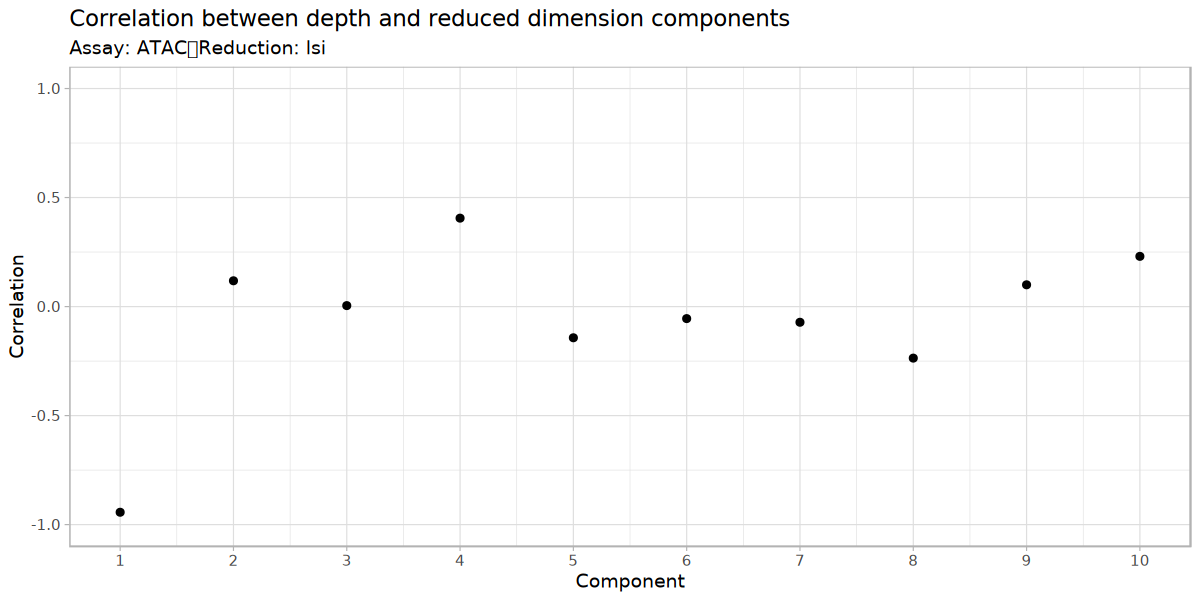

In [55]:
options(repr.plot.width=10, repr.plot.height=5)
DepthCor(filtered)
filtered

## Get ATAC-only UMAP and ATAC clusters

In [56]:
filtered <- RunUMAP(
  object = filtered,
  reduction = 'lsi',
  dims = 2:30
)

filtered

05:42:01 UMAP embedding parameters a = 0.9922 b = 1.112

05:42:01 Read 2328 rows and found 29 numeric columns

05:42:01 Using Annoy for neighbor search, n_neighbors = 30

05:42:01 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:42:01 Writing NN index file to temp file /tmp/RtmpEkW2OB/filec6a62c699df6

05:42:01 Searching Annoy index using 1 thread, search_k = 3000

05:42:02 Annoy recall = 100%

05:42:04 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:42:07 Initializing from normalized Laplacian + noise (using RSpectra)

05:42:07 Commencing optimization for 500 epochs, with 92734 positive edges

05:42:16 Optimization finished



An object of class Seurat 
346288 features across 2328 samples within 1 assay 
Active assay: ATAC (346288 features, 346288 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: lsi, umap

In [57]:
filtered <- FindNeighbors(
  object = filtered,
  reduction = 'lsi',
  dims = 2:30
)

filtered

Computing nearest neighbor graph

Computing SNN



An object of class Seurat 
346288 features across 2328 samples within 1 assay 
Active assay: ATAC (346288 features, 346288 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: lsi, umap

In [58]:
filtered <- FindClusters(
  object = filtered,
  algorithm = 3,
  resolution = 1.2,
  verbose = FALSE
)

filtered

An object of class Seurat 
346288 features across 2328 samples within 1 assay 
Active assay: ATAC (346288 features, 346288 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: lsi, umap

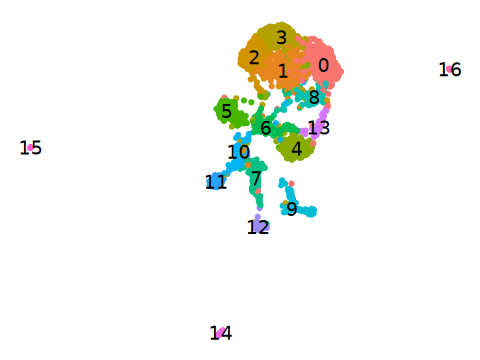

In [59]:
options(repr.plot.width=4, repr.plot.height=3)

# Create UMAP plot without axes and labels
umap_plot <- DimPlot(object = filtered, label = TRUE) + 
  NoLegend() + 
  theme_void() + # Remove axes and labels
  theme(legend.position = "none") # Ensure no legend

# Display the plot
umap_plot

In [60]:
table(filtered$seurat_clusters)


  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16 
383 330 231 223 191 173 134 128 109 108  88  83  55  53  24   8   7 

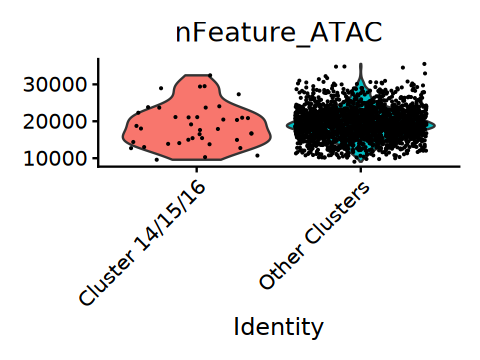

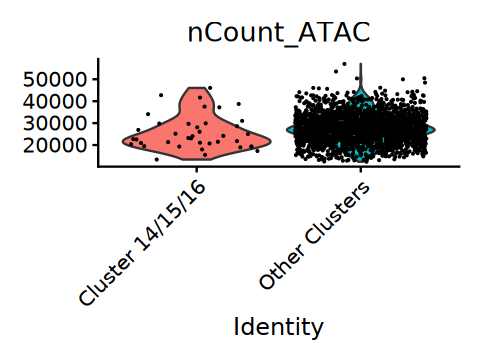

In [61]:
# Subset the Seurat object to highlight clusters 14, 15, 16
filtered$highlight <- ifelse(filtered$seurat_clusters %in% c(14, 15, 16), "Cluster 14/15/16", "Other Clusters")

# Generate violin plots for nFeature_ATAC
VlnPlot(filtered, features = "nFeature_ATAC", group.by = "highlight", pt.size = 0.1) + 
    theme(legend.position = "none") +
    ggtitle("nFeature_ATAC")

# Generate violin plots for nCount_ATAC
VlnPlot(filtered, features = "nCount_ATAC", group.by = "highlight", pt.size = 0.1) + 
    theme(legend.position = "none") +
    ggtitle("nCount_ATAC")


# Save plots

In [62]:
# Ensure the directory exists
if (!dir.exists(plot_save_dir_qc)) {
  dir.create(plot_save_dir_qc, recursive=TRUE)
}

In [63]:
# Save scatter5_marg as PDF with sample name appended
ggsave(file.path(plot_save_dir_qc, paste0(sample, "_QC_scatter.pdf")), 
       plot = scatter5_marg, device = "pdf", dpi = 300, width = 10, height = 5)

# Save combined_plot (FragmentHistogram | TSSPlot) as PDF with sample name appended
ggsave(file.path(plot_save_dir_qc, paste0(sample, "_FragmentDistribution_TSS.pdf")), 
       plot = combined_plot, device = "pdf", dpi = 300, width = 10, height = 5)

# Save umap_plot as PDF with sample name appended
ggsave(file.path(plot_save_dir_qc, paste0(sample, "_filtered_UMAP_unlabeled.pdf")), 
       plot = umap_plot, device = "pdf", dpi = 300, width = 2.5, height = 2)


# Save object

In [64]:
saveRDS_path_filt <- paste0(save_dir, '/2_filtered_objects/', sample, ".ATAC.filtered.Seurat.v5.rds")

saveRDS(filtered, file = saveRDS_path_filt)

print(paste('Saved filtered RDS to:', saveRDS_path_filt))

filtered
Version(filtered)

[1] "Saved filtered RDS to: /oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/2_filtered_objects/E2.ATAC.filtered.Seurat.v5.rds"


An object of class Seurat 
346288 features across 2328 samples within 1 assay 
Active assay: ATAC (346288 features, 346288 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: lsi, umap

[1] '5.0.2'

# END